### For filtering, spike detection and sorting to obtain single unit activity (discard MUAs)

In [86]:
import pandas as pd
import os
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#### Filtering

In [77]:
data = pd.read_csv('/Users/jazlynn/Downloads/neurons-csv-format/neuron_180.csv')

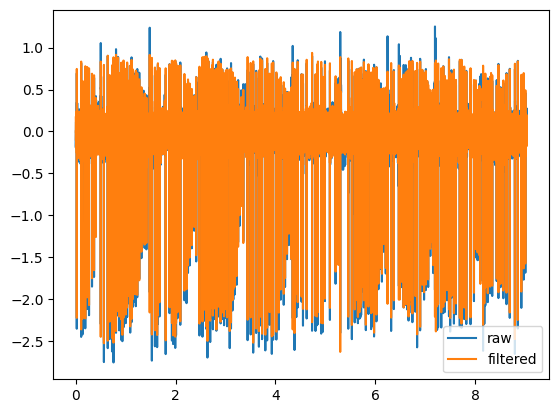

In [79]:
# change no need wrapper... use filtfilt

# Apply a bandpass filter to isolate the frequency range of interest
lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

filtered_data = butter_bandpass_filter(data['Voltage'], lowcut, highcut, fs)
plt.plot(data['Time'], data['Voltage'], label='raw')
plt.plot(data['Time'],filtered_data, label='filtered')
plt.legend()
# plt.xlim(2.85,2.854) # one AP
# plt.xlim(1,1.5)

#### find peaks

(13000.0, 15000.0)

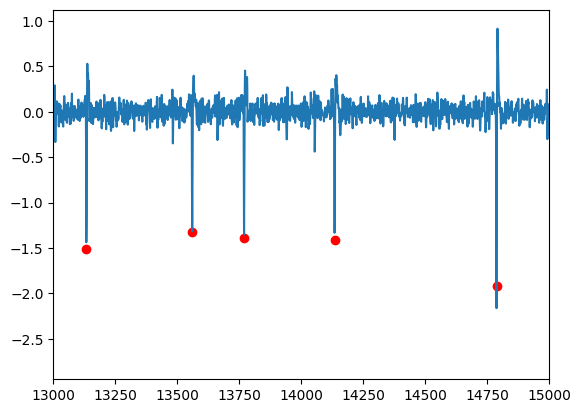

In [81]:
# Find peaks in the filtered data above a certain threshold
threshold = 3.0  # Adjust this threshold as needed
spike_peaks, _ = find_peaks(-filtered_data, height=-np.percentile(filtered_data,0.7))
plt.plot([i for i in range(len(data))],filtered_data, label='filtered')
plt.scatter(spike_peaks,data['Voltage'].iloc[spike_peaks], label = 'spikes', color='red')
plt.xlim(13000,15000)

In [76]:
np.percentile(filtered_data,0.7)

-0.1140628679856861

#### waveforms and clustering

In [29]:
window_size = 50  # Adjust as needed
spike_waveforms = []
for peak in spike_peaks:
    if peak - window_size >= 0 and peak + window_size < len(filtered_data):
        spike_waveforms.append(filtered_data[peak - window_size: peak + window_size])
spike_waveforms = np.array(spike_waveforms)

# Apply PCA for dimensionality reduction
n_components = 3  # Adjust as needed
pca = PCA(n_components=n_components)
waveform_features = pca.fit_transform(spike_waveforms)

# Cluster the waveforms using K-means
n_clusters = 4  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(waveform_features)

/Users/jazlynn/opt/anaconda3/envs/NP/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Viz

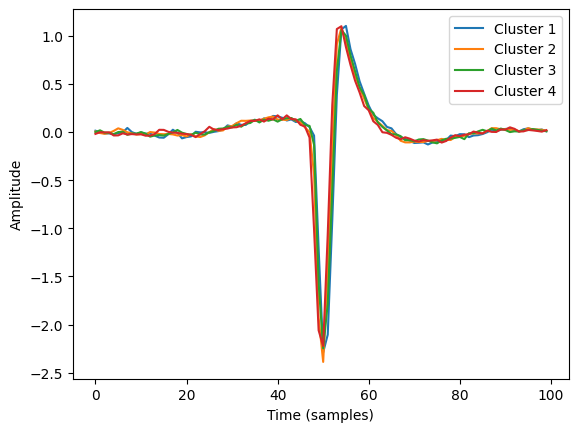

In [31]:
# Visualize the clustered waveforms
for i in range(n_clusters):
    cluster_waveforms = spike_waveforms[cluster_labels == i]
    mean_waveform = np.mean(cluster_waveforms, axis=0)
    plt.plot(mean_waveform, label=f'Cluster {i + 1}')

plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Process all neurons

In [96]:
lowcut = 300  # Low cutoff frequency in Hz
highcut = 6000  # High cutoff frequency in Hz
fs = 12500  # Sampling frequency in Hz
window_size = 25  # half of what the algorithm looks at when clustering
n_components = 3  # number of PCA components
cluster_numbers = [i for i in range(2,6)]

figure_idx = 0
fig, axes = None, None

for neuron in range(1,360+1):
    file = os.path.join('/Users/jazlynn/Downloads/neurons-csv-format','neuron_' + str(neuron).zfill(3) + '.csv')
    if os.path.exists(file):
        data = pd.read_csv(file)
        filtered_data = butter_bandpass_filter(data['Voltage'], lowcut, highcut, fs)
        spike_peaks, _ = find_peaks(-filtered_data, height=-np.percentile(filtered_data,0.7))
        
        spike_waveforms = []
        for peak in spike_peaks:
            if peak - window_size >= 0 and peak + window_size < len(filtered_data):
                spike_waveforms.append(filtered_data[peak - window_size: peak + window_size])
        spike_waveforms = np.array(spike_waveforms)

        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=n_components)
        waveform_features = pca.fit_transform(spike_waveforms)

        si_score = []
        for n_clusters in cluster_numbers:
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            cluster_labels = kmeans.fit_predict(waveform_features)
            si_score.append(silhouette_score(waveform_features, cluster_labels, metric='euclidean'))
            
        opt_n_clusters = cluster_numbers[np.argmax(si_score)]
        print(opt_n_clusters)
        
        kmeans = KMeans(n_clusters=opt_n_clusters, random_state=0, n_init='auto')
        cluster_labels = kmeans.fit_predict(waveform_features)
        
        # plt.figure()
        # plt.title(file)
        # for i in range(opt_n_clusters):
        #     cluster_waveforms = spike_waveforms[cluster_labels == i]
        #     mean_waveform = np.mean(cluster_waveforms, axis=0)
        #     plt.plot([j/(fs/1000) for j in range(-window_size,window_size)],mean_waveform, label=f'{np.sum(cluster_labels==i)} spikes')
        #     plt.xlabel('Time (ms)')
        #     plt.ylabel('Amplitude')
        #     plt.legend()
            
        if figure_idx % 9 == 0:
            if fig is not None:
                    plt.tight_layout()
                    # Save the figure
                    fig.savefig(os.path.join('Group5_spikesorting_QC', f'figure_{figure_idx//9}.png'))
                    plt.close(fig)
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))
            plt.suptitle(f'Figures {figure_idx//9 + 1}-{figure_idx//9 + 1}')

        i, j = figure_idx % 9 // 3, figure_idx % 9 % 3
        
        for k in range(opt_n_clusters):
            cluster_waveforms = spike_waveforms[cluster_labels == k]
            mean_waveform = np.mean(cluster_waveforms, axis=0)
            axes[i, j].plot([t/(fs/1000) for t in range(-window_size,window_size)],mean_waveform, label=f'{np.sum(cluster_labels==k)} spikes')
        
        axes[i, j].set_title('neuron ' + str(neuron))
        axes[i, j].set_xlabel('Time (ms)')
        axes[i, j].set_ylabel('Amplitude')
        axes[i, j].legend()
        figure_idx += 1

# last fig
if fig is not None:
    plt.tight_layout()
    # Save the last figure
    fig.savefig(os.path.join('Group5_spikesorting_QC', f'figure_{figure_idx//9}.png'))
    plt.close(fig)

2
4
4
2
3
2
3
5
2
4
3
2
3
2
3
2
4
3
2
2
2
5
2
2
3
2
2
2
3
2
2
2
2
4
4
2
3
3
4
4
4
5
2
2
2
2
2
2
2
2
2
4
2
5
4
3
4
2
3
5
5
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
5
2
2
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
4
2
2
2
2
2
2
2
2
2
3
2
3
2
2
3
4
2
2
3
2
2
2
2
4
2
2
2
3
4
2
3
2
2
2
2
2
2
3
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
4
2
4
2
2
4
2
2
2
2
2
2
2
2
2
3
2
4
2
2
2
2
2
4
3
2
2
3
2
2
2
2
3
2
3
3
2
2
2
2
3
2
4
2
2
2
2
2
2
2
3
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
3
2
4
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
2
3
2
2
2
2
3
2
2
2
2
2
3
2
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
2
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
5
2
2
2
2
3
2
2
2
2
2
4
2
2
2
